## eoAPI in Action - Afghanistan Earthquakes WIP

In [36]:
import IPython
!python -m pip install httpx ipyleaflet
IPython.display.clear_output(wait=False)


In [37]:
from datetime import datetime
import json

import httpx
import ipyleaflet

In [38]:
stac_endpoint = "https://eoapi.ifrc-risk.k8s.labs.ds.io/stac"

## Finding Signs of Impact

In [58]:
collection_id = "MAXAR_afghanistan_earthquake22"

collection_info = httpx.get(f"{stac_endpoint}/collections/{collection_id}").json()
bboxes = collection_info["extent"]["spatial"]["bbox"]
print(f"Number of spatial extents: {len(bboxes)}")
print(f"First spatial extent bounding box: \n {bboxes[0]}")

Number of spatial extents: 16
First spatial extent bounding box: 
 [69.183655, 25.87190729678215, 89.49113890637808, 33.32974207664388]


In [59]:
geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            'type': 'Feature',
            'geometry': {
                'type': 'Polygon',
                'coordinates': [[
                    [bbox[0], bbox[1]],
                    [bbox[2], bbox[1]],
                    [bbox[2], bbox[3]],
                    [bbox[0], bbox[3]],
                    [bbox[0], bbox[1]],
                ]]
            },
            'properties': {}
        }
        for bbox in bboxes
    ]
}

mainbbox = collection_info["extent"]["spatial"]["bbox"][0]

m = ipyleaflet.leaflet.Map(
    center=((mainbbox[1] + mainbbox[3]) / 2,(mainbbox[0] + mainbbox[2]) / 2),
    zoom=5
)

geo_json = ipyleaflet.leaflet.GeoJSON(data=geojson)
m.add_layer(geo_json)
m

Map(center=[29.60082468671302, 79.33739695318904], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [60]:
temporal_extents = collection_info["extent"]["temporal"]['interval']
print(f"Number of temporal extents: {len(temporal_extents)}")
print(f"Temporal extent: \n {temporal_extents[0]}")

Number of temporal extents: 1
Temporal extent: 
 ['2021-06-09T06:13:36Z', '2022-06-27T06:09:09Z']


In [100]:
# checking that the temporal extents are actually all the same!
temporal_extent = temporal_extents[0]
score = 0
for ext in temporal_extents:
    if ext != temporal_extent:
        print(ext)
        score += 1
score

0

In [62]:
! pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.4 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.7 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 5.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


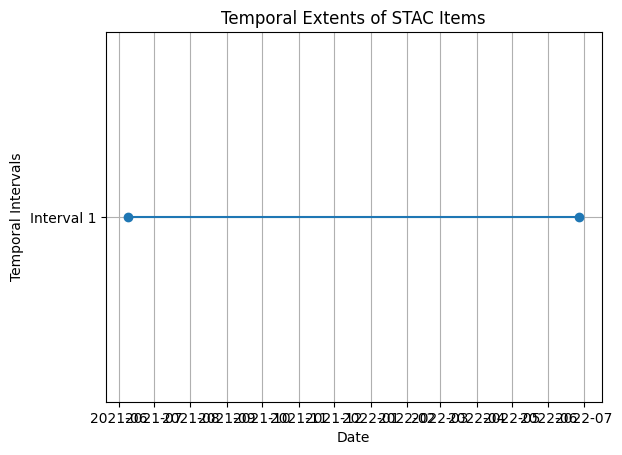

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.parser import parse

# Assuming temporal_extents is a list of intervals, like [[start1, end1], [start2, end2], ...]
temporal_extents = collection_info["extent"]["temporal"]['interval']  

# Convert date strings to datetime objects
dates = []
for interval in temporal_extents:
    start, end = interval
    start_date = parse(start)
    end_date = parse(end)
    dates.append([start_date, end_date])

# Plotting
fig, ax = plt.subplots()

# Create a line for each temporal extent
for i, (start, end) in enumerate(dates):
    plt.plot([start, end], [i, i], marker='o')  # Adjust marker style as needed

# Improve formatting
plt.yticks(range(len(dates)), ["Interval " + str(i+1) for i in range(len(dates))])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Temporal Intervals')
plt.title('Temporal Extents of STAC Items')
plt.grid(True)

# Show the plot
plt.show()


#### How to Query STAC Items

Querying items in STAC (SpatioTemporal Asset Catalog) involves accessing individual datasets within a collection. Each item in a STAC collection represents a distinct spatiotemporal asset, such as a satellite image or geographical survey data. These items are the fundamental units of STAC, containing metadata and links to the actual data.

To begin querying items, we must use the `id` of the collection under which the items are defined. To query the Kahramanmaras collection's items, we will use the following URL:

In [68]:
collection_id = "MAXAR_afghanistan_earthquake22"
items_url = f"{stac_endpoint}/collections/{collection_id}/items"

In [69]:
items = httpx.get(items_url).json() 
print(json.dumps(items['features'][0], indent=4))

{
    "id": "42_120200023233_10300100C04CC000",
    "bbox": [
        69.59817747885819,
        33.25591082321473,
        69.64618038085693,
        33.30406643126264
    ],
    "type": "Feature",
    "links": [
        {
            "rel": "collection",
            "type": "application/json",
            "href": "https://eoapi.ifrc-risk.k8s.labs.ds.io/stac/collections/MAXAR_afghanistan_earthquake22"
        },
        {
            "rel": "parent",
            "type": "application/json",
            "href": "https://eoapi.ifrc-risk.k8s.labs.ds.io/stac/collections/MAXAR_afghanistan_earthquake22"
        },
        {
            "rel": "root",
            "type": "application/json",
            "href": "https://eoapi.ifrc-risk.k8s.labs.ds.io/stac/"
        },
        {
            "rel": "self",
            "type": "application/geo+json",
            "href": "https://eoapi.ifrc-risk.k8s.labs.ds.io/stac/collections/MAXAR_afghanistan_earthquake22/items/42_120200023233_10300100C04CC000"


In [71]:
afg_items = []

url = items_url
while True:
    items = httpx.get(url, params={"limit": 200}).json()
    
    afg_items.extend(items["features"])
    next_link = list(filter(lambda link: link["rel"] == "next", items["links"]))
    if next_link:
        url = next_link[0]["href"]
    else:
        break

print(f"Actual Number of Items: {len(afg_items)}")


Actual Number of Items: 92


With all the items, we can start visualizing some important details that will help with our pre and post event analysis. The code block below generates a heatmap of the STAC items where we fill the color of pre-event Items with Blue and post-event Items with Red. 

In [73]:
m = ipyleaflet.leaflet.Map(
    center=((mainbbox[1] + mainbbox[3]) / 2,(mainbbox[0] + mainbbox[2]) / 2),
    zoom=7
)

geojson = ipyleaflet.leaflet.GeoJSON(data={"type": "FeatureCollection", "features": afg_items}, style_callback=style_function)
m.add_layer(geojson)
m

Map(center=[29.60082468671302, 79.33739695318904], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [49]:
raster_endpoint = "https://eoapi.ifrc-risk.k8s.labs.ds.io/raster"

In [74]:
item = items["features"][0]

print(list(item["assets"].keys()))
print(json.dumps(item["assets"]["visual"], indent=4))

for name, asset in item["assets"].items():
    print(name, ": ", asset["type"])

['visual', 'data-mask', 'ms_analytic', 'pan_analytic']
{
    "href": "https://maxar-opendata.s3.amazonaws.com/events/afghanistan-earthquake22/ard/42/120200023233/2021-06-09/10300100C04CC000-visual.tif",
    "type": "image/tiff; application=geotiff; profile=cloud-optimized",
    "roles": [
        "visual"
    ],
    "title": "Visual Image",
    "eo:bands": [
        {
            "name": "BAND_R",
            "common_name": "red",
            "description": "Red"
        },
        {
            "name": "BAND_G",
            "common_name": "green",
            "description": "Green"
        },
        {
            "name": "BAND_B",
            "common_name": "blue",
            "description": "Blue"
        }
    ],
    "proj:bbox": [
        554843.75,
        3679843.75,
        560156.25,
        3685156.25
    ],
    "proj:shape": [
        17408,
        17408
    ],
    "proj:transform": [
        0.30517578125,
        0.0,
        554843.75,
        0.0,
        -0.30517578125

Each Item of Maxar's collection has four assets, and three are cloud-optimized! Here's how we can use the raster API to visualize them.

First, we must retrieve the Raster metadata for each Raster asset. The raster API will default filter non-raster datasets using the asset's `type` metadata. In the example below, we are fetching the metadata for the `visual`, `ms_analytic`, and `pan_analytic` because these assets have a cloud-optimized type:

In [75]:
item_id = item["id"]

info = httpx.get(f"{raster_endpoint}/collections/{collection_id}/items/{item_id}/info").json()

print(json.dumps(info["visual"], indent=4))

for name, asset in info.items():
    print(name, asset["minzoom"], asset["maxzoom"])

{
    "bounds": [
        69.58879606109966,
        33.25591082321473,
        69.64618038085693,
        33.30410999935452
    ],
    "minzoom": 12,
    "maxzoom": 19,
    "band_metadata": [
        [
            "b1",
            {}
        ],
        [
            "b2",
            {}
        ],
        [
            "b3",
            {}
        ]
    ],
    "band_descriptions": [
        [
            "b1",
            ""
        ],
        [
            "b2",
            ""
        ],
        [
            "b3",
            ""
        ]
    ],
    "dtype": "uint8",
    "nodata_type": "Mask",
    "colorinterp": [
        "red",
        "green",
        "blue"
    ],
    "driver": "GTiff",
    "count": 3,
    "width": 17408,
    "height": 17408,
    "overviews": [
        2,
        4,
        8,
        16,
        32,
        64
    ]
}
visual 12 19
ms_analytic 12 16
pan_analytic 12 18


In [76]:
tilejson = httpx.get(
    f"{raster_endpoint}/collections/{collection_id}/items/{item_id}/tilejson.json",
    params = (
        ("assets", "visual"),  # THIS PARAMETER IS MANDATORY
        ("minzoom", 12),  # By default the tiler will use 0
        ("maxzoom", 19), # By default the tiler will use 24
    )
).json()
tilejson

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['http://eoapi.ifrc-risk.k8s.labs.ds.io/raster/collections/MAXAR_afghanistan_earthquake22/items/42_120200023233_10300100C04CC000/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=visual'],
 'minzoom': 12,
 'maxzoom': 19,
 'bounds': [69.59817747885819,
  33.25591082321473,
  69.64618038085693,
  33.30406643126264],
 'center': [69.62217892985757, 33.27998862723868, 12]}

In [77]:
bounds = tilejson["bounds"]
m = ipyleaflet.leaflet.Map(
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=12
)

geo_json = ipyleaflet.leaflet.GeoJSON(
    data=item,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0., 'weight': 4
    }
)
m.add_layer(geo_json)

tiles = ipyleaflet.leaflet.TileLayer(
    url=tilejson["tiles"][0],
    min_zoom=tilejson["minzoom"],
    max_zoom=tilejson["maxzoom"],
    bounds=[
        [bounds[1], bounds[0]],
        [bounds[3], bounds[2]],

    ],
)

m.add_layer(tiles)

m

Map(center=[33.27998862723868, 69.62217892985757], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [98]:
event_date = "2023-02-06T00:00:00Z"
f"{raster_endpoint}/mosaic/register"
# mosaic = httpx.post(
#     f"{raster_endpoint}/mosaic/register",
#     data=json.dumps(
#         {
#             "filter-lang": 'cql2-json',
#             "filter": {
#                 "op": 'and', 
#                 "args": [
#                     {
#                         "op": "in", 
#                         "args": [{"property": "collection"}, [collection_id]]
#                     },
#                 ],
#             },
#             "metadata":{
#                 "name": "Afg mosaic",
#             }
            
#         }
#     )
# ).json()
# mosaic

'https://eoapi.ifrc-risk.k8s.labs.ds.io/raster/mosaic/register'